In [ ]:
# impport the essential libraries
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import datasets, transforms
import pickle as pkl
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# set random seed
random.seed(777)
torch.manual_seed(777)

In [ ]:
# Use GPU
use_cuda = torch.cuda.is_available()

# Import dataset and apply data agumentation
img_to_tensor = transforms.ToTensor()
 
# resize the image and conduct some basic augmentations
# convert images to grey scale images 
transform_train_grey = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize((48, 48)),
                                transforms.RandomRotation(10),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
                                transforms.RandomAffine(degrees=0, shear=5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])
                                

transform_test_grey = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize((48, 48)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

# convert images to rgb images 
transform_train_RGB = transforms.Compose([transforms.Resize((48, 48)),
                                transforms.RandomRotation(10),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
                                transforms.RandomAffine(degrees=0, shear=5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test_RGB = transforms.Compose([transforms.Resize((48, 48)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
# define the image path                
data_dir = 'sample_data/data/MMAFEDB_new/'

In [ ]:
# Load the validation, test, and train data
train_data_grey = datasets.ImageFolder(data_dir + 'train', transform_train_grey)
test_data_grey = datasets.ImageFolder(data_dir + 'test', transform_test_grey)
valid_data_grey = datasets.ImageFolder(data_dir + 'valid', transform_test_grey)

train_data_RGB = datasets.ImageFolder(data_dir + 'train', transform_train_RGB)
test_data_RGB = datasets.ImageFolder(data_dir + 'test', transform_test_RGB)
valid_data_RGB = datasets.ImageFolder(data_dir + 'valid', transform_test_RGB)

In [ ]:
# Build dataloader in torch
test_loader_grey = DataLoader(test_data_grey, batch_size=256, shuffle=False)
valid_loader_grey = DataLoader(valid_data_grey, batch_size=256, shuffle=False)
train_loader_grey = DataLoader(train_data_grey, batch_size=1024, shuffle=True)

test_loader_RGB = DataLoader(test_data_RGB, batch_size=256, shuffle=False)
valid_loader_RGB = DataLoader(valid_data_RGB, batch_size=256, shuffle=False)
train_loader_RGB = DataLoader(train_data_RGB, batch_size=1024, shuffle=True)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=5, stride = 1, padding = 2)
        self.bn1 = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.ELU(),
        )
        self.conv2 = nn.Conv2d(32,64,kernel_size=5, stride = 1, padding = 2)
        self.bn2 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
        )
        self.conv3 = nn.Conv2d(64,128,kernel_size=3, stride = 1, padding = 1)
        self.bn3 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ELU(),
        )
        self.conv4 = nn.Conv2d(128,128,kernel_size=3, stride = 1, padding = 1)
        self.bn4 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
        )
        self.conv5 = nn.Conv2d(128,256,kernel_size=3, stride = 1, padding = 1)
        self.bn5 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv6 = nn.Conv2d(256,256,kernel_size=3, stride = 1, padding = 1)
        self.bn6 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
        )
        
        self.fc1 = nn.Linear(9216,128)
        self.fc2 = nn.Linear(128,7)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)
        nn.init.kaiming_normal_(self.conv6.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

        self.drop = nn.Sequential(
            nn.ELU(),
            nn.Dropout(0.6),
        )

    def forward(self,x):
        
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.conv6(x)
        x = self.bn6(x)
        #print(x.shape)
        x = x.view(batch_size, -1)
        #print(x.shape)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.drop = nn.Dropout(0.2)
        self.fc1 = nn.Linear(3*48*48,512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,7)


    def forward(self,x):
        
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x= F.relu(self.fc1(x))
        x = self.drop(x)
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        return x

In [ ]:
#training  function
def train(model, train_loader, test_loader, val_loader, lr = 0.001, GPU_device = False, Epoch = 80, opt = 'Nadam'):
  #set optimizer
  if opt == 'Nadam':
    optimizer = torch.optim.NAdam(model.parameters(), lr, betas=(0.9, 0.999), eps=1e-07)
  elif opt == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr)
  #set a schedular 
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
  #use a exp-weight loss
  weights = np.exp(-1*np.array([6566.0, 3231.0, 4859.0, 28592.0, 29384.0, 2223.0, 8113.0])/75000)/np.sum(
    np.exp(-1*np.array([6566.0, 3231.0, 4859.0, 28592.0, 29384.0, 2223.0, 8113.0])/75000))
  class_weights = torch.FloatTensor(weights)
  #set loss function for train
  criterion1 = nn.CrossEntropyLoss(weight=class_weights)
  #set loss function for val
  criterion2 = nn.CrossEntropyLoss()
  running_loss = 0.0
  min_loss = 100000.0
  model_dir = '/content/drive/My Drive/STAT3007/best_model_cnn.pt'
  val_acc = []
  test_acc = []
  tr_loss = []
  val_loss = []
  
  for epoch in range(Epoch):
      count = 0
      model.train()
      all_preds = torch.tensor([])
      targets = torch.tensor([])
      tr_sum_loss = 0
      #train the model using training set
      for batch_idx, data in enumerate(train_loader):
          #print(batch_idx)
          inputs, target = data
          size = target.size(0)
          count += size
          if GPU_device:
              inputs = inputs.cuda()
              target = target.cuda()
              model.cuda()

          outputs = model(inputs)
          loss = criterion1(outputs, target)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          tr_sum_loss += loss.item()
      tr_loss.append(tr_sum_loss/(batch_idx+1))
      scheduler.step()
      model.eval()
      total = 0
      correct = 0
      val_sum_loss = 0.0
      all_preds = torch.tensor([])
      targets = torch.tensor([])
      flag = 0
      with torch.no_grad():
          #test the model on validation set
          for batch_idx, data in enumerate(val_loader):
              inputs, target = data
              if GPU_device:
                  inputs = inputs.cuda()
                  target = target.cuda()
              outputs = model(inputs)
              loss = criterion2(outputs, target)
              _, predicted = torch.max(outputs.data, dim=1)
              total += target.size(0)
              correct += (predicted == target).sum().item()
              val_sum_loss += loss.item()
          val_sum_loss = val_sum_loss/(batch_idx+1)
          val_loss.append(val_sum_loss)
          #save the model if the val loss get smaller
          if val_sum_loss < min_loss:
            torch.save(model,model_dir)
            print('Model updates')
            min_loss = val_sum_loss
            flag = 1
                      
          acc = 100.0 * correct / total
          val_acc.append(acc)
          print(('Epoch: %d, Accuracy on val set: %f %% [%d  /  %d]' % (epoch+1, acc, correct, total)))
      
      total = 0
      correct = 0
      ts_sum_loss = 0.0
      all_preds = torch.tensor([])
      targets = torch.tensor([])
      #test the model on test set
      with torch.no_grad():
          for batch_idx, data in enumerate(test_loader):
              inputs, target = data
              if GPU_device:
                  inputs = inputs.cuda()
                  target = target.cuda()
              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, dim=1)
              all_preds = torch.cat((all_preds, outputs.cpu()),dim=0)
              targets = torch.cat((targets, target.cpu()),dim=0)
              total += target.size(0)
              correct += (predicted == target).sum().item()
                      
          acc = 100.0 * correct / total
          test_acc.append(acc)
      if flag == 1:
          print(classification_report(np.array(targets), all_preds.argmax(dim=1),digits = 3))

  return val_acc, test_acc, tr_loss, val_loss
      

In [ ]:
def plt_loss(tr_loss, val_loss, tw = 30):
  plt.plot([i for i in range(tw)], tr_loss, 'r--', label = 'Training loss')
  plt.plot([i for i in range(tw)], val_loss, 'b--', label = 'Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss against epochs')
  plt.legend()
  plt.plot()
  plt.show()

def plt_acc(val_acc, tw = 30):
  plt.plot([i for i in range(tw)], val_acc, 'k--', label = 'Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Validation accuracy against epochs')
  plt.legend()
  plt.plot()
  plt.show()

In [ ]:
import torchvision

In [ ]:
#CNN + NAdam
model_cnn = CNN()
val_acc_cnn, test_acc_cnn, tr_loss_cnn, val_loss_cnn = train(model_cnn, train_loader_grey, test_loader_grey, valid_loader_grey)

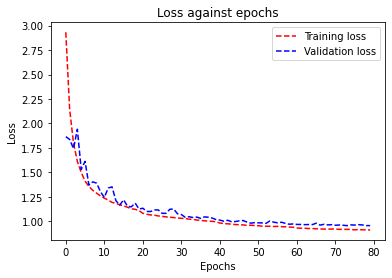

In [ ]:
#Loss of CNN + NAdam
plt_loss(tr_loss_cnn, val_loss_cnn)

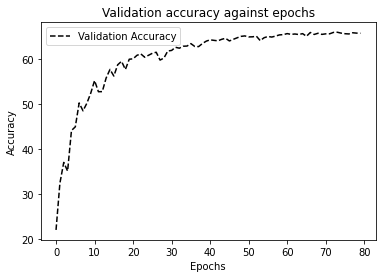

In [ ]:
#Val acc of CNN + NAdam
plt_acc(val_acc_cnn)

In [ ]:
#Pre-trained ResNet18 + NAdam
resnet18 = torchvision.models.resnet18(pretrained = True)
fc_features = resnet18.fc.in_features 
resnet18.fc = nn.Linear(fc_features, 7)
val_acc_resnet18, test_acc_resnet18, tr_loss_resnet18, val_loss_resnet18 = train(resnet18, train_loader_RGB, test_loader_RGB, valid_loader_RGB, lr = 0.0001)

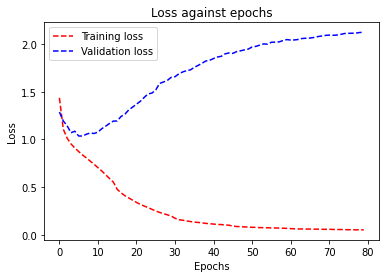

In [ ]:
#Loss of Pre-trained ResNet18 + NAdam
plt_loss(tr_loss_resnet18, val_loss_resnet18, 80)

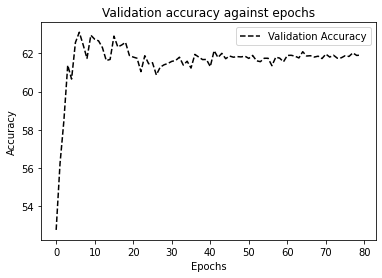

In [ ]:
#Val acc of Pre-trained ResNet18 + NAdam
plt_acc(val_acc_resnet18, 80)

In [ ]:
#Pre-trained ResNet34 + NAdam
resnet34 = torchvision.models.resnet34(pretrained = True)
fc_features = resnet34.fc.in_features 
resnet34.fc = nn.Linear(fc_features, 7)
val_acc_resnet34, test_acc_resnet34, tr_loss_resnet34, val_loss_resnet34 = train(resnet34, train_loader_RGB, test_loader_RGB, valid_loader_RGB, lr = 0.0001)

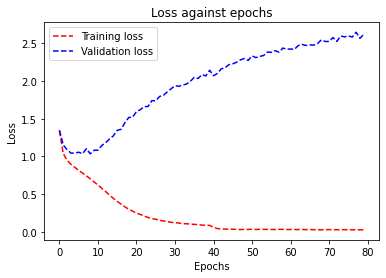

In [ ]:
#Loss of Pre-trained ResNet34 + NAdam
plt_loss(tr_loss_resnet34, val_loss_resnet34, 80)

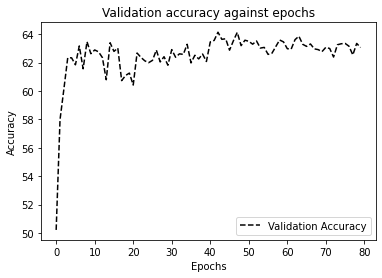

In [ ]:
#Val acc of Pre-trained ResNet34 + NAdam
plt_acc(val_acc_resnet34, 80)